# Training an Object Detection Model on Automatically Annotated Images

## 🌟 Overview
In this tutorial, we'll go through the process of automatic image annotation and training a custom object detection model. We'll first create a dataset, set up the training configuration, and then use it to train our own NN model. We'll also validate the performance of our model, export it, and make it ready for deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️installation)
- [🗃️ Data Preparation](#data-preparation)
    - [🧐 Generating Object Detection Annotation](#generating-dataset)
    - [💾 LuxonisDataset](#luxonisdataset)
- [🏋️‍♂️ Training](#️️training)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)

<a name ="️installation"></a>

## 🛠️ Installation

The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) together with [`DataDreamer`](https://github.com/luxonis/datadreamer). [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) is a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. [`DataDreamer`](https://github.com/luxonis/datadreamer) is an advanced toolkit for generating synthetic datasets and annotating images using the latest foundational models. We'll download our pictures from [`Kaggle`](https://www.kaggle.com/), generate annotations and store them in `LuxonisDataset`.

In [ ]:
%pip install -q kaggle datadreamer>=0.2.0 luxonis-train>=0.2.1 luxonis-ml>=0.5.1 -U

<a name ="data-preparation"></a>

## 🗃️ Data Preparation

First, we need to download and prepare our dataset. For this example, we'll use a publicly available dataset from Kaggle called [`Cats and Dogs 40`](https://www.kaggle.com/datasets/stefancomanita/cats-and-dogs-40). This dataset is originally an image classification dataset. However, we will utilize the aforementioned [`DataDreamer`](https://github.com/luxonis/datadreamer) toolkit to generate object detection annotation for the images. Therefore, our task is to train a model that is able to detect cats and dogs. 

To download the dataset, we'll run this:

In [ ]:
!kaggle datasets download -d stefancomanita/cats-and-dogs-40 -p downloaded_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/stefancomanita/cats-and-dogs-40
License(s): CC0-1.0
  0%|                                                | 0.00/445k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 445k/445k [00:00<00:00, 16.5MB/s]


We'll move images to one place:

In [ ]:
!mkdir catsdogs_dataset
!for file in ./downloaded_dataset/catsAndDogs40/train/cat/*.jpg; do mv "$file" "${file%.*}_train_cat.${file##*.}"; done && cp ./downloaded_dataset/catsAndDogs40/train/cat/*.jpg ./catsdogs_dataset/
!for file in ./downloaded_dataset/catsAndDogs40/train/dog/*.jpg; do mv "$file" "${file%.*}_train_dog.${file##*.}"; done && cp ./downloaded_dataset/catsAndDogs40/train/dog/*.jpg ./catsdogs_dataset/
!for file in ./downloaded_dataset/catsAndDogs40/test/cat/*.jpg; do mv "$file" "${file%.*}_test_cat.${file##*.}"; done && cp ./downloaded_dataset/catsAndDogs40/test/cat/*.jpg ./catsdogs_dataset/
!for file in ./downloaded_dataset/catsAndDogs40/test/dog/*.jpg; do mv "$file" "${file%.*}_test_dog.${file##*.}"; done && cp ./downloaded_dataset/catsAndDogs40/test/dog/*.jpg ./catsdogs_dataset/
!ls ./catsdogs_dataset/ | wc -l

80


<a name ="generating-dataset"></a>

### 🧐 Generating Object Detection Annotation

Now, we will use the [`DataDreamer`](https://github.com/luxonis/datadreamer) toolkit to annotate the `80` images. The toolkit will detect cats and dogs in each image and generate bounding boxes for each animal. Furthermore, using `--dataset_format luxonis-dataset` will convert the data to the correct format: `LuxonisDataset`, which we need for the training.

To discover all available DataDreamer arguments, please refer to [here](https://github.com/luxonis/datadreamer?tab=readme-ov-file#-main-parameters).

In [ ]:
!datadreamer --save_dir catsdogs_dataset \
            --class_names cat dog \
            --prompts_number 80 \
            --num_objects_range 1 1 \
            --synonym_generator wordnet \
            --image_annotator owlv2 \
            --annotator_size large \
            --annotate_only \
            --disable_lm_filter \
            --conf_threshold 0.4 \
            --annotation_iou_threshold 0.5 \
            --dataset_name cats_dogs_luxonis_dataset \
            --dataset_format luxonis-dataset \
            --split_ratios 0.7 0.15 0.15 \
            --batch_size_annotation 2 \
            --seed 123

Now, let's visualize the generated bounding boxes for one image.

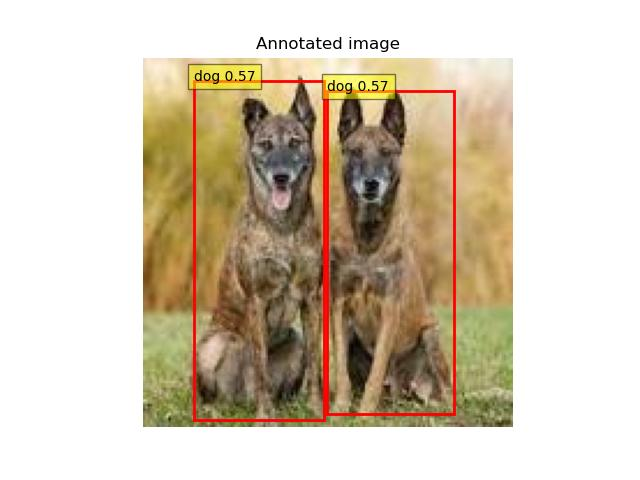

In [5]:
from IPython.display import Image
Image(filename='catsdogs_dataset/bboxes_visualization/bbox_5.jpg')

<a name ="luxonisdataset"></a>

### 💾 LuxonisDataset

Thanks to the `DataDreamer`, our dataset is already in the correct format: `LuxonisDataset`.

We can check the dataset's information and visualizations of the annotations to verify that the data is correctly loaded and split into subsets.

In [6]:
!luxonis_ml data info cats_dogs_luxonis_dataset

╭────────── Dataset Info ──────────╮
│ Name: cats_dogs_luxonis_dataset  │
│                                  │
│ ╭─ Split Sizes ─╮                │
│ │ train: 56     │                │
│ │ val: 12       │                │
│ │ test: 12      │                │
│ │ ───────────── │                │
│ │ Total: 80     │                │
│ ╰───────────────╯                │
│             Classes              │
│ ╭────────────────┬─────────────╮ │
│ │ Task           │ Class Names │ │
│ ├────────────────┼─────────────┤ │
│ │ classification │ cat, dog    │ │
│ │ boundingbox    │ cat, dog    │ │
│ ╰────────────────┴─────────────╯ │
╰──────────────────────────────────╯


In [ ]:
!luxonis_ml data inspect cats_dogs_luxonis_dataset # NOTE: If you are on Google Colab this command will not work

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="️configuration"></a>

### ⚙️ Configuration

We have prepared the dataset and are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task and then edit it to fit your needs.

In our case, we are training an object detection, and thus we'll take a [`detection_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/detection_light_model.yaml) config as a starting point, which downloads pre-trained COCO weights, making it ideal for fine-tuning. There are many parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

#### Model
In this section, you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a completely custom neural network by connecting different nodes, losses, metrics, and visualizers. We'll go with the predefined `DetectionModel`.

#### Loader
This section of the config refers to the data loading. You can either set up your custom `Loader` or use the default one with the `LuxonisDataset`. In our case, we'll go with the second option; all we need to do is set `dataset_name` to `cats_dogs_luxonis_dataset`.

#### Trainer
In this section, we can set up everything connected to the actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers, and more. Please refer to the [complete documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

#### Augmentations
In this tutorial, we'll leave most things as they are; the only change will be adding some augmentations. `Luxonis-train` uses [`Albumentations`](https://albumentations.ai/) for augmentations by adding custom ones like `Mosaic4` and `MixUp`. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your specific training run. In this training run, we'll add `Affine`, `HorizontalFlip` and `ColorJitter` augmentations, but feel free to edit this.

#### Callbacks 
Callbacks are very helpful when merging more functionalities into a single training run. For example, we want to train the model, evaluate it on a test subset, export it, and create an archive. These steps can be defined through the config and done by a single call. We won't use them in this tutorial for a more straightforward explanation but feel free to set them up independently. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks).

Below is a starting point for our config. As mentioned before, we already made some changes to it, so it works with this tutorial (model name and dataset name change, addition of augmentations), but feel free to edit it further and make it your own. When you are done editing, you can execute the cell, and the file will be written and ready to use.

**Note**: In case you don't have enough computing power on your machine, you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled), or you can try tweaking the training hyperparameters (such as lowering number of epochs or batch size). However, please be aware that bad parametrization can result in worse performance.

In [15]:
%%writefile cat_dog_detection_config.yaml
model:
  name: cat_dog_detection_model
  predefined_model:
    name: DetectionModel
    params:
      variant: light
      loss_params:
        iou_type: "siou"
        n_warmup_epochs: 0 # No assigner warmup
        iou_loss_weight: 20 # Should be 2.5 * accumulate_grad_batches for best results
        class_loss_weight: 8 # Should be 1 * accumulate_grad_batches for best results

loader:
  params:
    dataset_name: cats_dogs_luxonis_dataset

trainer:
  preprocessing:
    train_image_size: [320, 320]
    keep_aspect_ratio: true
    normalize:
      active: true
    augmentations:
      - name: Affine
        params:
          scale: [0.7, 1.7]
          rotate: 20
          shear: 5
          p: 0.3
      - name: HorizontalFlip
        params:
          p: 0.3
      - name: ColorJitter
        params:
          brightness: [0.8, 1.2]
          contrast: [0.8, 1.2]
          saturation: [0.8, 1.2]
          hue: 0
          p: 0.2
      - name: Sharpen
        params:
          p: 0.3

  batch_size: 8
  epochs: &epochs 70
  accumulate_grad_batches: 8 # For best results, always accumulate gradients to effectively use 64 batch size
  n_workers: 8
  validation_interval: 10
  n_log_images: 8

  callbacks:
    - name: EMACallback
      params:
        decay: 0.9999 
        use_dynamic_decay: True 
        decay_tau: 2000

  training_strategy: # Fine tuning params
    name: "TripleLRSGDStrategy"
    params: 
      warmup_epochs: 2
      warmup_bias_lr: 0.05
      warmup_momentum: 0.5
      lr: 0.0032
      lre: 0.0000384
      momentum: 0.843     
      weight_decay: 0.00036   
      nesterov: True

Overwriting cat_dog_detection_config.yaml


<a name ="train"></a>

### 🦾 Train

To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes but feel free to use them when you do it yourself.

In [ ]:
from luxonis_train import LuxonisModel

config_path = "cat_dog_detection_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [ ]:
RUN_NAME = "<YOUR_RUN_NAME>"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is an object detection task, we use the mean average precision metric to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [17]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

INFO     Loaded checkpoint from                                                            ]8;id=713518;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=494124;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#986\986]8;;\
         /home/jovyan/dai-ml-training/output/182-lavender-lizard/min_val_loss/cat_dog_dete                         
         ction_model_loss=7.2226_69.ckpt.                                                                          

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=732945;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=662718;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: EMACallback, ModelCheckpoint, RichModelSummary,                     
         TrainingManager                                                                                           

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO     Computing metrics on test subset ...                                              ]8;id=697473;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=563380;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#816\816]8;;\

INFO     Metrics computed.                                                                 ]8;id=805636;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=662174;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#818\818]8;;\

INFO     Test loss: 7.9920                                                                ]8;id=969654;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=286649;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1041\1041]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 7.991967439651489

Metrics:

         EfficientBBoxHead-boundingbox         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name                             ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ MeanAveragePrecision-boundingbox │ 0.75609  │
│ map_50                           │ 0.95050  │
│ map_75                           │ 0.88366  │
│ map_small                        │ -1.00000 │
│ map_medium                       │ -1.00000 │
│ map_large                        │ 0.75609  │
│ mar_1                            │ 0.71061  │
│ mar_10                           │ 0.79242  │
│ mar_100                          │ 0.79242  │
│ mar_small                        │ -1.00000 │
│ mar_medium                       │ -1.00000 │
│ mar_large                        │ 0.79242  │
│ f1_small                         │ -1.00000 │
│ f1_medium                        │ -1.00000 │
│ f1_large                         │ 0.77383  │
└──────────────────────────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric                                                                 ]8;id=335715;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=30238;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1050\1050]8;;\
         (EfficientBBoxHead-boundingbox/MeanAveragePrecision-boundingbox): 0.7561                                  

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       test/loss                        │                    7.99196720123291                    │
│ test/loss/EfficientBBoxHead-boundingbox/AdaptiveDetec… │                    7.99196720123291                    │
│ test/loss/EfficientBBoxHead-boundingbox/AdaptiveDetec… │                    0.74022376537323                    │
│ test/loss/EfficientBBoxHead-boundingbox/AdaptiveDetec… │                  0.10350887477397919                   │
│ test/metric/EfficientBBoxHead-boundingbox/MeanAverage… │                   0.7560890913009644                   │
│   test/metric/EfficientBBoxHead-boundingbox/f1_large   │                   0.7738303542137146                   │
│  test/metric/EfficientBBoxHead-boundingbox/f1_medium   │                          -1.0                          │
│   test/metric/EfficientBBoxHead-boundingbox/f1_small   │                          -1.0                          │
│    test/metric/EfficientBBoxHead-boundingbox/map_50    │                   0.9504950642585754                   │
│    test/metric/EfficientBBoxHead-boundingbox/map_75    │                   0.8836633563041687                   │
│  test/metric/EfficientBBoxHead-boundingbox/map_large   │                   0.7560890913009644                   │
│  test/metric/EfficientBBoxHead-boundingbox/map_medium  │                          -1.0                          │
│  test/metric/EfficientBBoxHead-boundingbox/map_small   │                          -1.0                          │
│    test/metric/EfficientBBoxHead-boundingbox/mar_1     │                   0.710606038570404                    │
│    test/metric/EfficientBBoxHead-boundingbox/mar_10    │                   0.7924242615699768                   │
│   test/metric/EfficientBBoxHead-boundingbox/mar_100    │                   0.7924242615699768                   │
│  test/metric/EfficientBBoxHead-boundingbox/mar_large   │                   0.7924242615699768                   │
│  test/metric/EfficientBBoxHead-boundingbox/mar_medium  │                          -1.0                          │
│  test/metric/EfficientBBoxHead-boundingbox/mar_small   │                          -1.0                          │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [ ]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_cats_dogs_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_cats_dogs_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

Now, let's visualize one of the predictions.

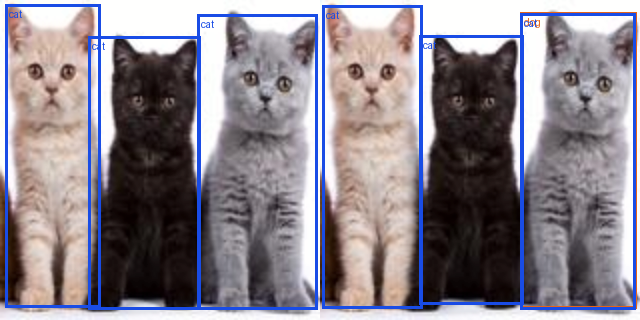

In [20]:
from IPython.display import Image
Image(filename='infer_results_cats_dogs_model/EfficientBBoxHead-boundingbox_BBoxVisualizer-boundingbox_7.png')

On the left above, we can see the annotation; on the right, we can see the prediction.

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [ ]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible.

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv@git+https://github.com/luxonis/modelconverter.git@main -U

We will use `ModelConverter`'s Python API, which utilizes our [`HubAI`](https://hub.luxonis.com) to convert the model in the background. To start with the conversion, you need to create an account on the `HubAI` platform and obtain the API key for your team.

To log in to HubAI, use the following command:

In [ ]:
!modelconverter hub login

To convert the model, we can use either CLI or Python API. We'll use the latter. For more information, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [ ]:
NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"

In [2]:
from modelconverter import convert

converted_model = convert(
    "rvc2",
    path=NN_ARCHIVE_PATH,
    name="Cats&Dogs Object Detection Model",
    description_short="Trained object detection model on the cats and dogs detection dataset.",
    tasks=["OBJECT_DETECTION"],
    license_type="MIT",
    is_public=False
)

Model 'Cats&Dogs Object Detection Model' created with ID 'fd8dd235-d0cd-487b-b5f6-8760c5980f91'

Model variant 'Cats&Dogs Object Detection Model 320x320' created with ID '6b97a5d5-6aba-480d-86f1-cb450b58d51a'

Model instance 'Cats&Dogs Object Detection Model 320x320 base instance' created with ID 
'8fbd5c59-7ec7-4e0d-b3a6-f2d717fd3323'

File 'cat_dog_detection_model.onnx.tar.xz' uploaded to model instance '8fbd5c59-7ec7-4e0d-b3a6-f2d717fd3323'

Model instance 'Cats&Dogs Object Detection Model 320x320 exported to rvc2' created for rvc2 export with ID 
'6e45a8b7-4dc8-4cb1-8d0a-9d758c6949c7'

/Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Donwloaded 'cats-dogs-object-detection-model-320x320-exported-to-rvc2/cat_dog_detection_model.rvc2.tar.xz'

We have successfully converted our trained model for an RVC2 device, so let's test it! Please copy the path to the downloaded archive with the converted model from the output log of the last code cell; we will use it in the next section.

In [ ]:
MODEL_PATH = "cats-dogs-object-detection-model-320x320-exported-to-rvc2/cat_dog_detection_model.rvc2.tar.xz"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name ="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we first need to install [`DepthAI`](https://rvc4.docs.luxonis.com/software/) in version 3 and [`DepthAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/). Moreover, the script we'll write must run locally and require a Luxonis device connected to your machine.

In [ ]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a10
%pip install -q depthai-nodes@git+https://github.com/luxonis/depthai-nodes.git@main -U

Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
import depthai as dai
from depthai_nodes import ParsingNeuralNetwork
import numpy as np


def visualize_detections_xyxy(frame: np.ndarray, message: dai.ImgDetections):
    """Visualize the detections on the frame.

    The detections are in xyxy format (dai.ImgDetections).
    """
    labels = ["cat", "dog"]
    detections = message.detections
    for detection in detections:
        xmin, ymin, xmax, ymax = (
            detection.xmin,
            detection.ymin,
            detection.xmax,
            detection.ymax,
        )
        if xmin > 1 or ymin > 1 or xmax > 1 or ymax > 1:
            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)
        else:
            xmin = int(xmin * frame.shape[1])
            ymin = int(ymin * frame.shape[0])
            xmax = int(xmax * frame.shape[1])
            ymax = int(ymax * frame.shape[0])
        cv2.rectangle(
            frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2
        )

        cv2.putText(
            frame,
            f"{detection.confidence * 100:.2f}%",
            (int(xmin) + 10, int(ymin) + 20),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            (255, 0, 0),
        )
        if labels is not None:
            cv2.putText(
                frame,
                labels[detection.label],
                (int(xmin) + 10, int(ymin) + 40),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                (255, 0, 0),
            )

    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True

    return False


with dai.Pipeline() as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((320, 320), type=dai.ImgFrame.Type.BGR888p, fps=30), 
        nn_archive
    )
    # Create output queues
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    # Start pipeline
    pipeline.start()

    while pipeline.isRunning():
        # Get the frame
        frame: dai.ImgFrame = frame_queue.get().getCvFrame()
        # Get the parsed message containing the bounding boxes
        parser_msg: dai.ImgDetections = parser_output_queue.get()
        if visualize_detections_xyxy(frame, parser_msg):
            pipeline.stop()
            break

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed an object detection model trained using `luxonis-train` on cats and dogs images annotated using `DataDreamer` to our camera!